# General Computations for Differentiating Arbitrary Policies for Rollout Bayesian Optimization
`Learning outcome`: Mapping computations required for solving rollout acquisition functions.
`Note`: Sections labelled with `Mathematical Considerations` will be for discussing concepts mathematically. Sections labelled with `Computational Considerations` will usually follow `Mathematical Considerations`, when we see fit, to map our mathematical ideas to computations.

Fixes:
* Use $K$ instead of $\sigma$ for the predictive variance since the equation for the predictive variance contains a noise variance term in terms of $\sigma$.
* Create variables for equations that appear throughout so changes are easy to incorporate.

## Introductory Remarks
In this discussion, we will examine the general problem of minimizing an unknown and potentially expensive-to-evaluate function $f(x)$. This is a common challenge in many applications, from hyperparameter tuning in machine learning to optimizing physical experiments. One powerful strategy for addressing this problem is Bayesian optimization, which efficiently searches for the minimum of $f(x)$ by building a probabilistic model that balances exploration of new regions of the search space with exploitation of known promising areas. By leveraging this model, Bayesian optimization can minimize $f(x)$ with fewer evaluations compared to traditional optimization methods.

First, I will introduce myopic Bayesian optimization, which focuses on selecting the next evaluation point based on immediate benefits, maximizing short-term improvements. While effective in many cases, myopic approaches can overlook long-term gains. To address this, we turn to non-myopic Bayesian optimization, which incorporates future consequences of current decisions, leading to more strategic and globally informed exploration.

A key element in non-myopic Bayesian optimization is the use of rollout acquisition functions. These functions balance exploration and exploitation by simulating potential future outcomes of the optimization process, guiding decisions that are expected to yield better results over multiple steps.

By understanding these approaches and their applications, we can enhance our ability to optimize complex systems more effectively and efficiently.

### Useful Notation
$$
\DeclareMathOperator*{\argmax}{arg\,max}
$$
We have some collection of regressors $X \in \mathbb{R}^{d \times n}$ and observations $\mathcal{\textbf{y}} \in \mathbb{R}^{n}$, where our dataset for our supervised machine learning model is denoted as $\mathcal{D}_n = \{(x_i, y_i) : 1 \leq i \leq n\}$. Given $\mathcal{D}_{n}$, we denote the predictive mean and predictive variance at some location $x$ as $\mu_n(x|\mathcal{D}_n)$ and $k_n(x|\mathcal{D}_n)$ respectively. In general, we'll suppress the parameter $\mathcal{D}_n$, and write $\mu_n(x)$ and $k_n(x)$.

## `Mathematical Considerations` Myopic Bayesian optimization
**Myopic Bayesian Optimization (MBO)** provides a strategy for this problem, typically using a Gaussian Process (GP) to model $f(x)$ based on the data gathered up to the current step, denoted as $D_n$.

In the myopic setting, the next evaluation point $x_{n+1}$ is selected by maximizing an acquisition function $\alpha(x \mid \mu_n(x), k_n(x), \theta)$, which uses the current model to decide where the next sample should be taken. This is done with a short-term perspective, looking only one step ahead:

$$
x_{n+1} = \argmax_{x \in \Omega} \; \alpha(x \mid \mu_n(x), k_n(x), \theta)
$$

The key characteristic of myopic Bayesian optimization is that it makes decisions based on maximizing some immediate reward, depending only on the observations made so far. While this approach is computationally efficient and often effective in practice, it tends to focus on short-term gains, optimizing for the current step without considering the long-term impact on the overall optimization process. Consequently, when we have more than one step remaining in our evaluation budget, myopic acquisition functions may overlook opportunities that would be better explored over the long term. This limitation highlights the need for strategies that account for future consequences, which non-myopic approaches aim to address.

## `Computational Considerations` Myopic Bayesian optimization
The function, $\alpha$, being maximized above is an acquisition function denoted as a `DecisionRule`. Constructing a `DecisionRule` consists of defining your function of interest in terms of $\mu, k, \theta, $ and `sx`. Here, `sx` is a lazy struct that consists of all the computations associated with our surrogate evaluated at some arbitrary location $x$. More details to come shortly, but we define functional handles that expose information you may find useful when defining your base policy. Let's consider perhaps the most popular example in the myopic setting, expected improvement (EI). 

In [5]:
include("../rollout_bayesian_optimization.jl")
using Distributions

In [6]:
# Here the predictive variance tolerance is hard-coded, but one could consider creating an outer function
# whose parameter is the noise tolerance term which generates functions once the desired tolerance is specified.
function ei(μ, k, θ, sx)
    if k < 1e-8 return 0. end
    
    fbest = minimum(get_observations(sx))
    improvement = fbest - μ - θ[1]
    z = improvement / k
    
    stdnormal = Distributions.Normal(0, 1)
    ϕz = Distributions.pdf(stdnormal, z)
    Φz = Distributions.cdf(stdnormal, z)

    expected_improvement = improvement * Φz + k * ϕz
    return expected_improvement
end

decision_rule = DecisionRule(ei, "EI")
bp_θ = [0.]; # Corresponds to setting exploration hyperparameter ξ = 0.

Now that we've setup our base policy, let's grab a toy problem and generate some data for our `Surrogate`. Our surrogate expects a `Kernel`, $X$, $y$, `BasePolicy` and $\sigma_n^2$.

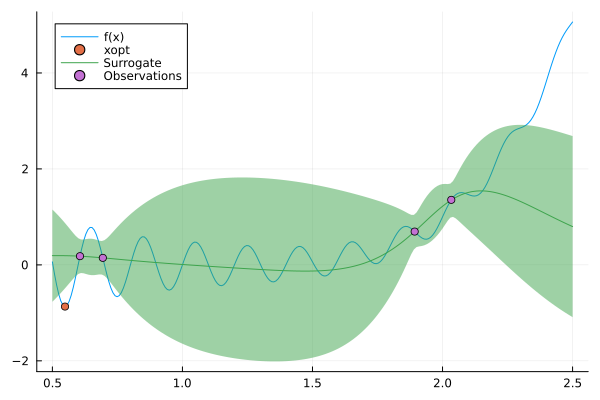

In [7]:
# Toy problem setup
N, σn2 = 4, 1e-3
testfn = TestGramacyLee()
lbs, ubs = get_bounds(testfn)
X = randsample(N, testfn.dim, lbs, ubs)
y = testfn(X)

# Discretize our domain
domain = range(first(lbs), first(ubs), step=.01)

# Arbitrary kernel selection
kernel = kernel_matern52([1.])
kernel_lbs, kernel_ubs = [0.1], [10.]

# Surrogate construction with kernel hyperparameters learned via MLE
sur = Surrogate(kernel, X, y, decision_rule=decision_rule, σn2=σn2)
sur = optimize(sur, kernel_matern52, lowerbounds=kernel_lbs, upperbounds=kernel_ubs);

# Collect predictive mean and variance of surrogate
predictive_mean = similar(domain)
predictive_variance = similar(domain)

for (i, x) in enumerate(domain)
    sx = sur([x], bp_θ)
    predictive_mean[i] = sx.μ
    predictive_variance[i] = sx.σ
end

# Visualize beliefs and toy function in 1D
tplot(testfn)
plot!(domain, predictive_mean, ribbons=2sqrt.(predictive_variance), label="Surrogate")
scatter!(sur.X', sur.y, label="Observations")

Now that we've constructed our surrogate and provided it with a base policy, we can evaluate the base policy at some arbitrary location $x$ as follows.

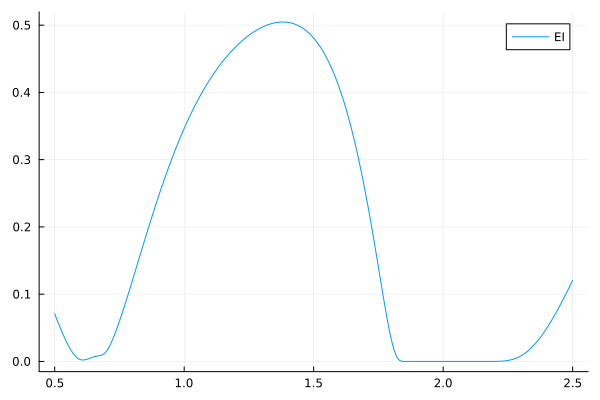

In [8]:
base_policy_eval = similar(domain)
for (i, x) in enumerate(domain)
    sx = sur([x], bp_θ)
    base_policy_eval[i] = eval(sx)
end

plot(domain, base_policy_eval, label="$(sur.g.name)")

We can subsequently optimize for this base policy using standard procedures, but we save details on this for brevity.

## `Mathematical Considerations` Non-myopic Bayesian optimization
**Non-myopic Bayesian optimization (NMBO)** frames the exploration-exploitation problem as a balance of immediate and future rewards. Lam et al. formulate NMBO as a finite-horizon dynamic program; the equivalent Markov decision process (MDP) follows.

The notation used is standard in Puterman: an MDP is a collection $(T, \mathbb{S}, \mathbb{A}, P, R)$, where $T = \{1,2,\dots,h\},$ and $h < \infty$ is the set of decision epochs, finite for our problem. The state space, $\mathbb{S}$, encapsulates the information needed to model the system from time $t \in T$, and $\mathbb{A}$ is the action space. Given a state $s \in \mathbb{S}$ and an action $a \in \mathbb{A}$, $P(s'|s,a)$ is the probability that the next state will be $s'$. $R(s,a,s')$ is the reward received for choosing action $a$ in state $s$ and transitioning to $s'$.

A decision rule $\pi_t : \mathbb{S} \to \mathbb{A}$ maps states to actions at time $t$. A policy $\pi$ is a series of decision rules $\pi = (\pi_1, \pi_2, \dots, \pi_h)$, one at each decision epoch. Given a policy $\pi$, a starting state $s_0$, and horizon $h$, we can define the expected total reward $V_h^\pi(s_0)$ as:

$$
  V_h^\pi(s_0) = \mathbb{E}\left[ \sum_{t=0}^{h-1} R(s_t, \pi_t(s_t), s_{t+1}) \right].
$$

Our objective is to find the optimal policy $\pi^*$ that maximizes the expected total reward, i.e., $\sup_{\pi \in \Pi} V_h^\pi(s_0)$, where $\Pi$ is the space of all admissible policies.

If we can sample from the transition probability $P$, we can estimate the expected total reward of any base policy — the decisions made using the base acquisition function — with Monte Carlo (MC) integration:

$$
  V_h^{\hat{\pi}}(s_0) \approx 
  \frac{1}{N} \sum_{i=1}^N \left[ \sum_{t=0}^{h-1} R(s_t^i, \hat{\pi}_t(s_t^i), s_{t+1}^i) \right].
$$

Given a Gaussian Process (GP) prior over data $\mathcal{D}_n$ with mean $m(x)$ and covariance function $k(x, x')$, we model $h$ steps of Bayesian optimization as an MDP. This MDP's state space is all possible data sets reachable from the starting state $\mathcal{D}_n$ with $h$ steps of Bayesian optimization. Its action space is $\Omega$; actions correspond to sampling a point in $\Omega$. Its transition probability and reward function are defined as follows. Given an action $\mathbf{x}_{n+1}$, the transition probability from $\mathcal{D}_n$ to $\mathcal{D}_{n+1}$, where $\mathcal{D}_{n+1} = \mathcal{D}_n \cup \{(\mathbf{x}_{n+1}, y_{n+1})\}$ is:

$$
  P(\mathcal{D}_n, \mathbf{x}_{n+1}, \mathcal{D}_{n+1}) \sim 
  \mathcal{N}(\mu_{n}(\mathbf{x}_{n+1}), k_{n}(\mathbf{x}_{n+1})).
$$

Thus, the transition probability from $\mathcal{D}_n$ to $\mathcal{D}_{n+1}$ is the probability of sampling $y_{n+1}$ from the posterior $\mathcal{GP}$ at $\mathbf{x}_{n+1}$. The reward function $R(\mathcal{D}_n, \mathbf{x}_{n+1}, \mathcal{D}_{n+1})$ can be any general reward that reflects the value of transitioning from state $\mathcal{D}_n$ to state $\mathcal{D}_{n+1}$ after sampling $\mathbf{x}_{n+1}$. 

We define the non-myopic policy as the optimal solution to an $h$-horizon MDP. The expected total reward of this MDP is:

$$
  V_h^\pi(\mathcal{D}_n) = \mathbb{E}\left[ \sum_{t=n}^{n+h-1} R(\mathcal{D}_t, \pi_t(\mathcal{D}_t), \mathcal{D}_{t+1}) \right].
$$

When $h > 1$, the optimal policy is difficult to compute.

## `Mathematical Considerations` Rollout Acquisition Functions
$$
\newcommand{\bbR}{\mathbb{R}}
\newcommand{\bbN}{\mathbb{N}}
\newcommand{\bbE}{\mathbb{E}}
\newcommand{\calN}{\mathcal{N}}
\newcommand{\calD}{\mathcal{D}}
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\bfx}{\textbf{x}}
\newcommand{\bfy}{\textbf{y}}
\newcommand{\bfk}{\textbf{k}}
\newcommand{\xstart}{\bfx^{\mathrm{start}}}
\newcommand{\xnext}{\bfx^{\mathrm{next}}}
\newcommand{\ystart}{y_{\mathrm{start}}}
$$
Finding an optimal policy for the $h$-horizon MDP is hard, partly because of the expense of representing and optimizing over policy functions. One approach to faster approximate solutions to the MDP is to replace the infinite-dimensional space of policy functions with a family of trial policies described by a modest number of parameters. An example of this approach is *rollout* policies, which yield promising results for the $h$-step horizon MDP. For a given state $\calD_t$, we say that a base policy $\tilde{\pi} $ is a sequence of rules that determines the actions to be taken in various states of the system.

We denote our base policy for the $h$-horizon MDP as $\tilde{\pi} = (\tilde{\pi}_0, \tilde{\pi}_1, \tilde{\pi}_2, \dots, \tilde{\pi}_h)$. We let $\calD_n$ denote the initial state of our MDP and $\calD_{n, r}$ for $0 \leq r \leq h$ to denote the random variable that is the state at each decision epoch. The first decision is a random draw from our model where $\tilde{\pi}_0(\calD_n) = x_0$ with $y_0 | x_0 \sim \calN(\mu_n(x_0), k_n(x_0))$. Each subsequent decision $\tilde{\pi}_r$ for $r \geq 1$ consists of maximizing the base decision rule $\bar{\alpha}$ given the current state $\calD_{n, 0}$, i.e.

$$
  \tilde{\pi}_r = \argmax_{\bfx \in \Omega} \; \bar{\alpha} \left( \bfx | \calD_{n, r-1}\right).
$$

Using this policy, we define the non-myopic acquisition function $\alpha_h(\bfx)$ as the rollout of $\tilde{\pi}$ to horizon $h$, i.e. the expected reward of $\tilde{\pi}$ starting with action $\tilde{\pi}_0(\calD_n) = \xstart$:

$$
  \alpha_h\left( \xstart \right) 
  \coloneqq 
  \mathbb{E} \left[ V^{\tilde{\pi}}_{h} \left( \calD_{n} \cup \{ \left(\xstart, \ystart\right) \} \right) \right],
$$

where $\ystart | x_start \sim \calN(\mu_n(x_0), k_n(x_0))$. Thus, as is the case with any acquisition function, the next BO evaluation is:

$$
  \xnext = \argmax_{\xstart \in \;\Omega} \; \alpha_h\left(\xstart\right).
$$

Rollout is tractable and conceptually straightforward, however, it is still computationally demanding. To rollout $\tilde{\pi}$ once, we must do $h$ steps of BO with $\bar{\alpha}$. Many of the aforementioned rollouts must then be averaged to reasonably estimate $\alpha_h$, which is an $h$-dimensional integral. Estimation can be done either through explicit quadrature or MC integration, and is the primary computational bottleneck of rollout.

## `Computational Considerations` Rollout Acquisition Functions
